In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as lm
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Reshape,LSTM,Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.constraints import nonneg
import numpy as np
%matplotlib inline
import tensorflow
import keras
import math
import time
import datetime
from sklearn import cluster, datasets, metrics


Using TensorFlow backend.


In [3]:
oli = pd.read_csv('cleanoutwvd.csv')
olier = oli.copy();
#去掉當量暫時不用

olier.speed=(olier.speed);olier
olier.YY=olier.YY-16;
olier=olier.drop(['lane','direct','eqflow','fakeornot','realvd'],axis=1);olier
# olier['index'] = olier.index;olier

"""#佔有率標準化
olierc=olier.copy()
dfmin = olier.index.min().copy()
mxmin = olier.index.max().copy()-dfmin;
olierc.index =((olierc.index-dfmin)/(mxmin));olierc"""


# move speed to the end
# olierclo = olier.columns.tolist()

# olier= olier[olierclo[:-2]+olierclo[-1:]+olierclo[-2:-1]];

#0225version
def cleanout(inp,i):
    dfvdi= inp.where(inp['sortby']==i).dropna();

    outp = dfvdi.copy()
    # 某個時間要把fakeornot去掉 
    outpp = outp.values.astype('float32')
    # 分出train 跟test
    train_size = int(len(outpp) * 0.75)
    test_size = len(outpp) - train_size
    train, test = outpp[0:train_size,:], outpp[train_size:len(outpp),:]
    if (len(train)%168 != 0) or (len(test)%168 != 0) :
        train=train[:-(len(train)%168)]
        test=test[:-(len(test)%168)]
        
    return train,test


import time
start = time.time()

sortbylist=oli['sortby'].unique().tolist()
tralist = []
teslist = []

for i in sortbylist:
    temptra,temptes=cleanout(olier,i)
    #train
    for ele in temptra.tolist():
        tralist.append(ele)
    #test
    for ele3 in temptes.tolist():
        teslist.append(ele3)

cluster01tra=np.array(tralist)
print len(cluster01tra)
cluster01tes=np.array(teslist)
print len(cluster01tes)
print(start - time.time()),'seconds'

256536
85512
-4.84082007408 seconds


In [17]:
import time
start = time.time()
#起始隨機子
np.random.seed(7)
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-1,look_back):
        a = dataset[i:(i+look_back), 0:nort]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i+look_back+look_back, nort-1])
#     return dataX,dataY
    return np.array(dataX), np.array(dataY)

# 看資料有幾個欄位就寫幾
nort = 7
# magic number
look_back = 168
# cut off remainder
train = cluster01tra
test = cluster01tes
# check data lenth when cut off remainder
print(len(train), len(test))

# seperate data to input"X" and output"Y"
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
    
# create and fit Multilayer Perceptron model
model = Sequential()
# model = Model(input=look_back*nort,output=[look_back,2])

# RESHAPE is  working !!!!! >0<"
model.add(Reshape((look_back*nort,), input_shape=(look_back,nort)))
# Add layers to neruon network 
model.add(Dropout(0.3))
model.add(Dense(190,input_dim=(look_back*nort), activation='linear'))
model.add(LeakyReLU(alpha=.001)) 
model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(look_back, W_constraint=nonneg()))
model.compile(loss='mse', optimizer='adam')

model.fit(trainX, trainY, nb_epoch=168, batch_size=3, verbose=0)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
# print('Train Score: %.2f MAPE ' % trainScore)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
# print('Test Score: %.2f MAPE ' % testScore)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

print(start - time.time()),'seconds'



(256536, 85512)
Train Score: 23.73 MSE (4.87 RMSE)
Test Score: 2545.18 MSE (50.45 RMSE)
-483.998095989 seconds


In [ ]:
plt.plot(pre,color='r')

47.0207
48.0515517826
11.2213
12.4298372763


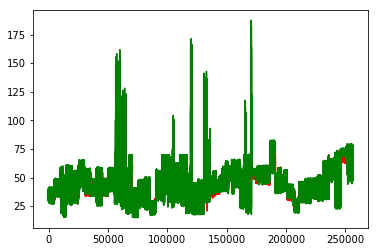

In [11]:
# model.save('model0303.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

pre = trainPredict.reshape(len(trainPredict)*len(trainPredict[0]),)
ori = trainY.reshape(len(trainY)*len(trainY[0]),)

print pre.mean()
print ori.mean()
print pre.std()
print ori.std()


# plt.ylabel(u'當量', fontsize=30)
# plt.xlabel(u'時間', fontsize=30)

plt.plot(pre,color='r')
# plt.plot(pre[-672:-336],color='b')
# plt.plot(pre[-1008:-672],color='r')
# plt.plot(pre[-1344:-1008],color='g')

plt.plot(ori,color='g')
# plt.savefig('0216.jpg')

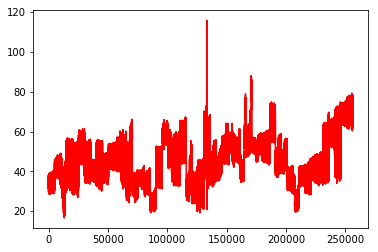

In [12]:
plt.plot(pre,color='r')

In [ ]:
#可以用佔有率分群 

for sortnum in sortbylist:
    wwp=olic.where(olic.sortby==sortnum).dropna().copy()
    print round(wwp['accu'].max(),3),"\t\t",round(wwp['accu'].mean(),4),"\t\t",sortnum

In [4]:
sortnum=29

wwp=oli.where(oli.sortby==sortnum).dropna().copy()
print wwp.realvd.unique()[0]
print wwp.direct.unique()[0]
sp45=wwp.speed.quantile(0.4);sp45
wwpcjam=wwp.where((wwp.speed<sp45)&(wwp.accu>5)).dropna().copy()

# jamli=wwpcjam.ix[:,['day','time']].set_index(['day','time']).index.unique().values.tolist();jamli.sort()
# for dd,tt in jamli:

i=4;j=8;n=18
rush = [(i-1,j-1),(i-1,j),(i-1,j+1),(i-1,j+2),(i-1,n-1),(i-1,n),(i-1,n+1),(i-1,n+2)]

for dd,tt in rush:
    alldaynum=wwp[(wwp.day==dd)&(wwp.time==tt)].count()[0]
    jamdaynum=wwpcjam[(wwpcjam.day==dd)&(wwpcjam.time==tt)].count()[0]
    print '星期',int(dd+1),'_',int(tt),'點'
    print round((float(jamdaynum)/alldaynum),4)*100,'%',wwp[(wwp.day==dd)&(wwp.time==tt)].eqflow.mean()
    

VPMSV40
4.0
星期 4 _ 7 點
0.0 % 623.834925263
星期 4 _ 8 點
17.07 % 1947.73085789
星期 4 _ 9 點
92.68 % 2097.50513667
星期 4 _ 10 點
70.73 % 2009.85412895
星期 4 _ 17 點
9.76 % 1855.12810488
星期 4 _ 18 點
19.51 % 1893.445
星期 4 _ 19 點
26.83 % 1736.7153439
星期 4 _ 20 點
7.32 % 1448.88133902


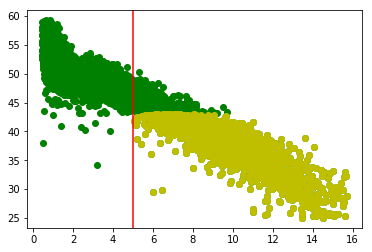

In [7]:
sortnum=8
wwp=oli.where(oli.sortby==sortnum).dropna().copy()
sp45=wwp.speed.quantile(0.45);sp45
wwpcjam=wwp.where((wwp.speed<sp45)&(wwp.accu>5)).dropna().copy()


plt.plot(wwp.accu,wwp.speed,'go')
# plt.plot(wwp.accu,wwp.eqflow,'go')


plt.plot(wwpcjam.accu,wwpcjam.speed,'yo')
# plt.axhline(y=sp45, xmin=0, xmax=wwp.accu.count(), color='r')
plt.axvline(5, color='r')

VPMSV40
4.0
星期 4 _ 7 點
0.0 % 623.834925263
星期 4 _ 8 點
17.07 % 1947.73085789
星期 4 _ 9 點
92.68 % 2097.50513667
星期 4 _ 10 點
70.73 % 2009.85412895
星期 4 _ 17 點
9.76 % 1855.12810488
星期 4 _ 18 點
19.51 % 1893.445
星期 4 _ 19 點
26.83 % 1736.7153439
星期 4 _ 20 點
7.32 % 1448.88133902


In [6]:
wwp

,realvd,sortby,direct,lane,YY,fakeornot,day,date,time,speed,accu,eqflow
199752,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,0.0,56.226580,1.223333,501.428560
199753,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,1.0,56.432495,0.813333,293.500000
199754,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,2.0,56.174507,0.636667,207.457610
199755,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,3.0,56.451843,0.460000,125.263160
199756,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,4.0,57.099094,0.446667,110.000000
199757,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,5.0,56.407146,0.476667,126.000000
199758,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,6.0,56.384403,0.673333,218.000000
199759,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,7.0,55.933903,1.533333,636.000000
199760,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,8.0,54.257877,5.143333,1987.118700
199761,VPMSV40,29.0,4.0,3.0,16.0,0.0,4.0,92.0,9.0,43.318230,10.053333,2231.579000


In [ ]:
# 塞車率！暫時還用不到，暫時。

import time
start = time.time()

olic=oli.copy()
olic['jamp']=0
sortbylist=olic.sortby.unique().tolist()

gt=[]
for ele in range(0,7):
    for ele2 in range(0,24):
        gt.append((ele,ele2))

for sortnum in sortbylist:
    
    wwp=olic.where(olic.sortby==sortnum).dropna().copy()
    # print wwp.realvd.unique()[0]
    # print wwp.direct.unique()[0]
    sp45=wwp.speed.quantile(0.4);sp45
    wwpcjam=wwp.where((wwp.speed<sp45)&(wwp.accu>5)).dropna().copy()

    for dd,tt in gt:
        alldaynum=wwp[(wwp.day==dd)&(wwp.time==tt)].count()[0]
        jamdaynum=wwpcjam[(wwpcjam.day==dd)&(wwpcjam.time==tt)].count()[0]
        
        perc =round((float(jamdaynum)/alldaynum),4)
        olic.loc[(olic.sortby==sortnum)&(olic.day==dd)&(olic.time==tt),'jamp']=perc

print(start - time.time()),'seconds'



In [ ]:
#0225version
def cleanout(inp,i):
    dfvdi= inp.where(inp['sortby']==i).dropna();

    outp = dfvdi.copy()
    # 某個時間要把fakeornot去掉 
    outpp = outp.values.astype('float32')
    # 分出train 跟test
    train_size = int(len(outpp) * 0.75)
    test_size = len(outpp) - train_size
    train, test = outpp[0:train_size,:], outpp[train_size:len(outpp),:]
    if (len(train)%168 != 0) or (len(test)%168 != 0) :
        train=train[:-(len(train)%168)]
        test=test[:-(len(test)%168)]
        
    return train,test
